## Proyecto Clasificación del Sueño con RandomForestClassifier.

### Importamos las librerias necesarias:

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

### Preprocesamiento de Datos:

### Cargamos los datos:

In [2]:
heart_rate = pd.read_csv('heart_rate.txt', header=None, names=['timestamp', 'heart_rate'])
labels = pd.read_csv('labels.txt', header=None, names=['timestamp', 'label'], delim_whitespace=True)
motion = pd.read_csv('motion.txt', header=None, names=['timestamp', 'x', 'y', 'z'], delim_whitespace=True)
steps = pd.read_csv('steps.txt', header=None, names=['timestamp', 'steps'])

### Convertimos los datos de tipo timestamp a datetime:

In [3]:
heart_rate['timestamp'] = pd.to_datetime(heart_rate['timestamp'], unit='s')
labels['timestamp'] = pd.to_datetime(labels['timestamp'], unit='s')
motion['timestamp'] = pd.to_datetime(motion['timestamp'], unit='s')
steps['timestamp'] = pd.to_datetime(steps['timestamp'], unit='s')

### Unimos los datos en un solo Dataframe:

In [4]:
data = pd.merge_asof(heart_rate, motion, on='timestamp')
data = pd.merge_asof(data, steps, on='timestamp')
data = pd.merge_asof(data, labels, on='timestamp')

### Eliminamos las las etiquetas con el valor -1, ya que solo haremos la clasificación desde el 0 al 5:

In [5]:
data = data[data['label'] != -1]

### Llenamos los valores nulos del Dataframe con los metodos ffill y bfill:

In [6]:
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

### Creamos los features finales de x,y,z con el metodo .diff() y nuevamente .fillna() para asegurarnos de que no quedan valores nulos:

In [7]:
data['x_diff'] = data['x'].diff().fillna(0)
data['y_diff'] = data['y'].diff().fillna(0)
data['z_diff'] = data['z'].diff().fillna(0)
data['heart_rate_diff'] = data['heart_rate'].diff().fillna(0)

### EDA de una dimensión:

### Movimiento (Aceleración):

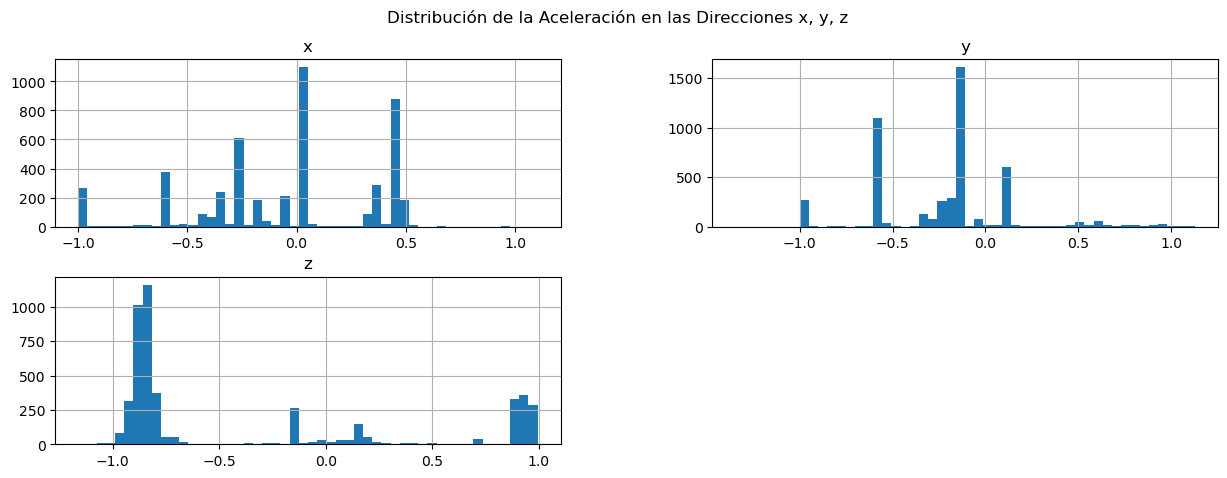

In [8]:
data[['x', 'y', 'z']].hist(bins=50, figsize=(15, 5))
plt.suptitle('Distribución de la Aceleración en las Direcciones x, y, z')
plt.show()

### Frecuencia cardíaca:

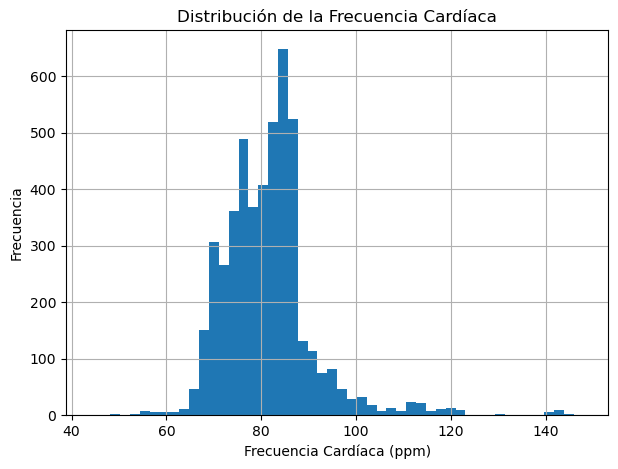

In [9]:
data['heart_rate'].hist(bins=50, figsize=(7, 5))
plt.title('Distribución de la Frecuencia Cardíaca')
plt.xlabel('Frecuencia Cardíaca (ppm)')
plt.ylabel('Frecuencia')
plt.show()

### Conteo de pasos:

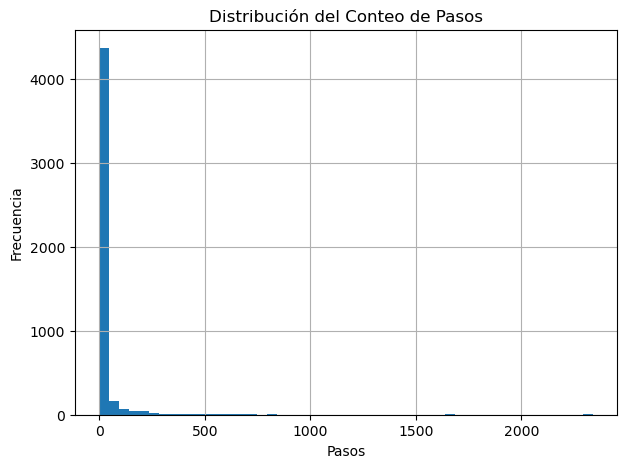

In [10]:
data['steps'].hist(bins=50, figsize=(7, 5))
plt.title('Distribución del Conteo de Pasos')
plt.xlabel('Pasos')
plt.ylabel('Frecuencia')
plt.show()

### Etiquetas del sueño:

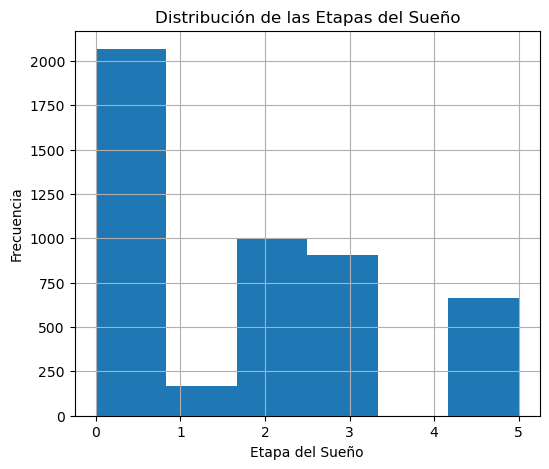

In [11]:
data['label'].hist(bins=6, figsize=(6, 5))
plt.title('Distribución de las Etapas del Sueño')
plt.xlabel('Etapa del Sueño')
plt.ylabel('Frecuencia')
plt.show()

### EDA de dos dimensiones:

### Correlación entre aceleración y frecuencia cardíaca:

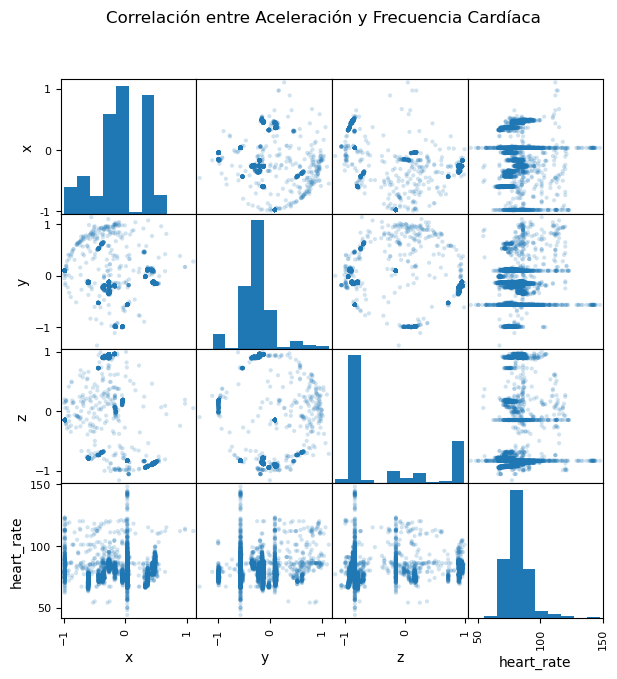

In [12]:
pd.plotting.scatter_matrix(data[['x', 'y', 'z', 'heart_rate']], figsize=(7, 7), alpha=0.2)
plt.suptitle('Correlación entre Aceleración y Frecuencia Cardíaca')
plt.show()

### Correlación entre conteo de pasos y frecuencia cardíaca:

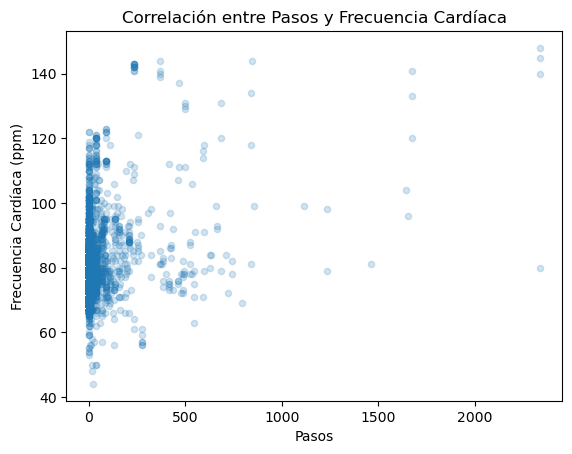

In [13]:
data.plot.scatter(x='steps', y='heart_rate', alpha=0.2)
plt.title('Correlación entre Pasos y Frecuencia Cardíaca')
plt.xlabel('Pasos')
plt.ylabel('Frecuencia Cardíaca (ppm)')
plt.show()

### Boxplot entre las distintas características del modelo (entradas) y las etapas del sueño (salida):

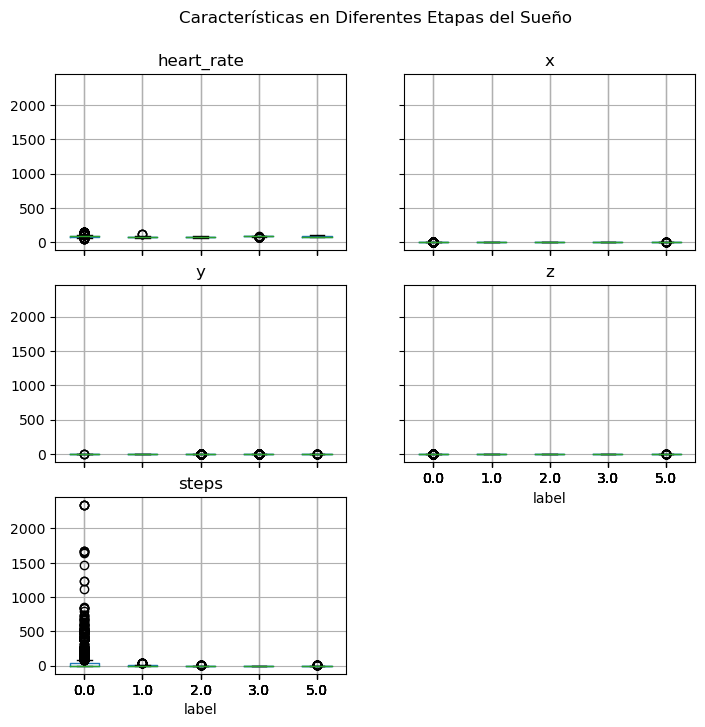

In [14]:
data.boxplot(column=['heart_rate', 'x', 'y', 'z', 'steps'], by='label', figsize=(8, 8))
plt.suptitle('Características en Diferentes Etapas del Sueño')
plt.show()

### Entrenamiento del modelo:

### Definimos las entradas (x) y las salidas (y) del modelo para poder entrenar el modelo y generar la predicción, siendo la salida 'label' el estado del sueño del paciente de 0 a 5:

In [15]:
X = data[['heart_rate', 'x', 'y', 'z', 'steps', 'x_diff', 'y_diff', 'z_diff', 'heart_rate_diff']]
y = data['label']

### Usamos el Imputer ''SimpleImputer'' con la estrategia 'mean' y su metodo .fit_transform() de Sklearn para manejar los valores restantes NaN de nuestro set de entrenamiento de las entradas (x):

In [16]:
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

### Creamos el set de entrenamiento y el set de pruebas con la función .train_test_split() de Skitlearn:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Entrenamos el modelo con "RandomForestClassifier" y su función .fit() de Sklearn:

In [18]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Predicción del modelo:

### Realizamos las predicciones del modelo con el metodo .predict() de RandomForestClassifier:

In [19]:
y_pred = clf.predict(X_test)

### Evaluación del modelo:

### Evaluamos el modelo con las funciones de metrica .classification_report() y .accuracy_score() de Sklearn:

In [20]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       642
         1.0       0.65      0.58      0.61        45
         2.0       0.84      0.88      0.86       288
         3.0       0.91      0.95      0.93       258
         5.0       0.97      0.94      0.95       208

    accuracy                           0.93      1441
   macro avg       0.87      0.86      0.87      1441
weighted avg       0.93      0.93      0.93      1441

Accuracy: 0.9299097848716169


### Usamos las curvas ROC y AUC para medir los verdaderos positivos y falsos positivos del modelo:

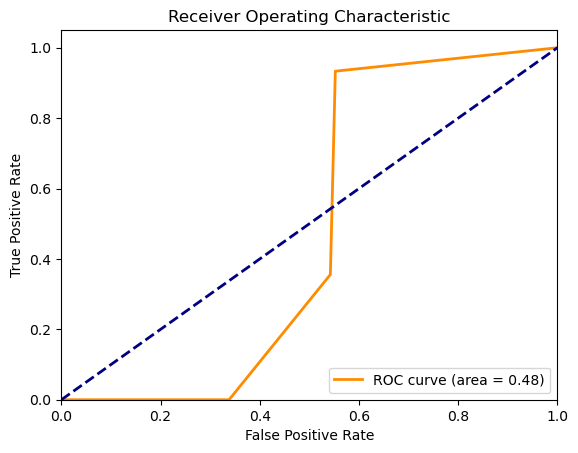

In [21]:
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Usamos la curva de precisión-recall para comparar la precisión y recall del modelo:

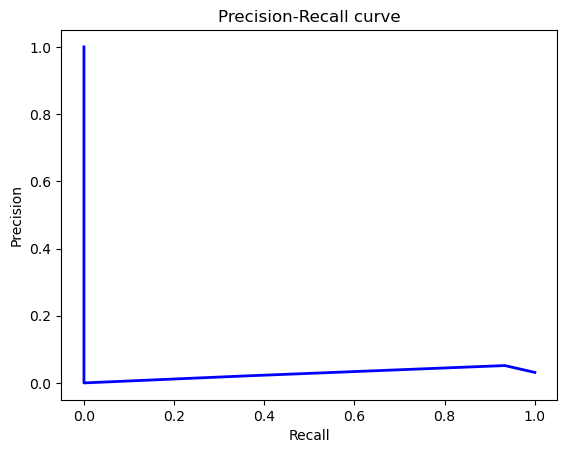

In [22]:
precision, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=1)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()